In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from math import pi

# 1. ROBUST PATH CONFIGURATION
# Matches the structure of your uploaded files
BASE_DIR = Path("results_attained") 
if not BASE_DIR.exists():
    # Fallback for notebook location
    BASE_DIR = Path("../results_attained")

OUTPUT_DIR = Path("Results")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# 2. IEEE PUBLICATION STYLE
sns.set_theme(style="whitegrid", context="paper", font_scale=1.6) # Increased font size
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']

# 3. CONSISTENT COLORS & MARKERS
# CLIP=Blue, LoRA=Red, Frozen=Green (Distinct & Colorblind-safe)
COLORS = {"CLIP": "#0072B2", "CLIP_LORA": "#D55E00", "FROZEN": "#009E73"}
MARKERS = {"CLIP": "^", "CLIP_LORA": "^", "FROZEN": "^"} # Uniform Triangles

print(f"✓ Configuration loaded. Saving plots to: {OUTPUT_DIR.resolve()}")

✓ Configuration loaded. Saving plots to: /sda/usama/production_code/visual_testing/Results


In [2]:
def load_all_data():
    records = []
    model_stats = {}
    class_reports = {} # Note: Your sample JSON doesn't show class reports, so this remains empty
    
    # Define models to look for
    models_to_check = ["CLIP", "CLIP_LORA", "FROZEN"]

    for model in models_to_check:
        model_path = BASE_DIR / model
        metrics_file = model_path / "metrics.json"
        
        # 1. Check if single metrics file exists
        if not metrics_file.exists():
            continue
            
        with open(metrics_file, 'r') as f:
            data = json.load(f)

        # 2. Extract High-Level Stats (Latency, Memory, Params)
        # We use .get({}, {}) patterns to prevent crashes if keys are missing
        lat_data = data.get("latency", {})
        mem_data = data.get("memory", {})
        param_data = data.get("parameters", {})
        eval_data = data.get("evaluation_results", {})

        throughput = lat_data.get("throughput_samples_per_second", 0)
        peak_mem = mem_data.get("inference_peak_gpu_mb", 0)
        
        # Calculate params in Millions
        # Note: Your JSON has "trainable_parameters" and "frozen_parameters"
        trainable = param_data.get("trainable_parameters", 0)
        frozen = param_data.get("frozen_parameters", 0)
        params_m = (trainable + frozen) / 1e6

        lp_accs = []

        # 3. Iterate through Evaluation Results
        # Your JSON structure is: Dataset Name -> Task Type -> Metrics
        for dataset_name, dataset_metrics in eval_data.items():
            ds_clean = dataset_name.upper()

            # --- Handle Linear Probe ---
            if "linear_probe" in dataset_metrics:
                # JSON: linear_probe -> accuracy
                lp_metric = dataset_metrics["linear_probe"]
                acc = lp_metric.get("accuracy", 0)
                lp_accs.append(acc)
                
                records.append({
                    "Model": model, 
                    "Task": "Linear Probe", 
                    "Dataset": ds_clean,
                    "Value": acc, 
                    "Throughput": throughput
                })

            # --- Handle Few-Shot ---
            if "few_shot" in dataset_metrics:
                # JSON: few_shot -> "1-shot" -> "accuracy_mean"
                for shot_key, shot_data in dataset_metrics["few_shot"].items():
                    # Parse "1-shot" to integer 1
                    try:
                        shots_count = int(shot_key.split('-')[0])
                    except:
                        shots_count = shot_key 

                    # Note: Key is 'accuracy_mean' in your new JSON, not just 'accuracy'
                    acc = shot_data.get("accuracy_mean", 0)
                    
                    records.append({
                        "Model": model, 
                        "Task": "Few-Shot", 
                        "Dataset": ds_clean,
                        "Shots": shots_count, 
                        "Accuracy": acc
                    })

            # --- Handle Zero-Shot (If present) ---
            if "zero_shot" in dataset_metrics:
                zs_metric = dataset_metrics["zero_shot"]
                # Adjust 'top1' to whatever key your zero_shot JSON actually uses
                acc = zs_metric.get("top1", zs_metric.get("accuracy", 0))
                
                records.append({
                    "Model": model, 
                    "Task": "Zero-Shot", 
                    "Dataset": ds_clean,
                    "Value": acc
                })

        # 4. Store Stats
        model_stats[model] = {
            "Throughput": throughput,
            "Memory": peak_mem,
            "Params_M": params_m,
            "Avg_LP_Acc": np.mean(lp_accs) if lp_accs else 0
        }

    return pd.DataFrame(records), model_stats, class_reports

# Execution
df, model_stats, class_reports = load_all_data()
print(f"✓ Data Loaded: {len(df)} records found across {len(model_stats)} models.")

✓ Data Loaded: 100 records found across 3 models.


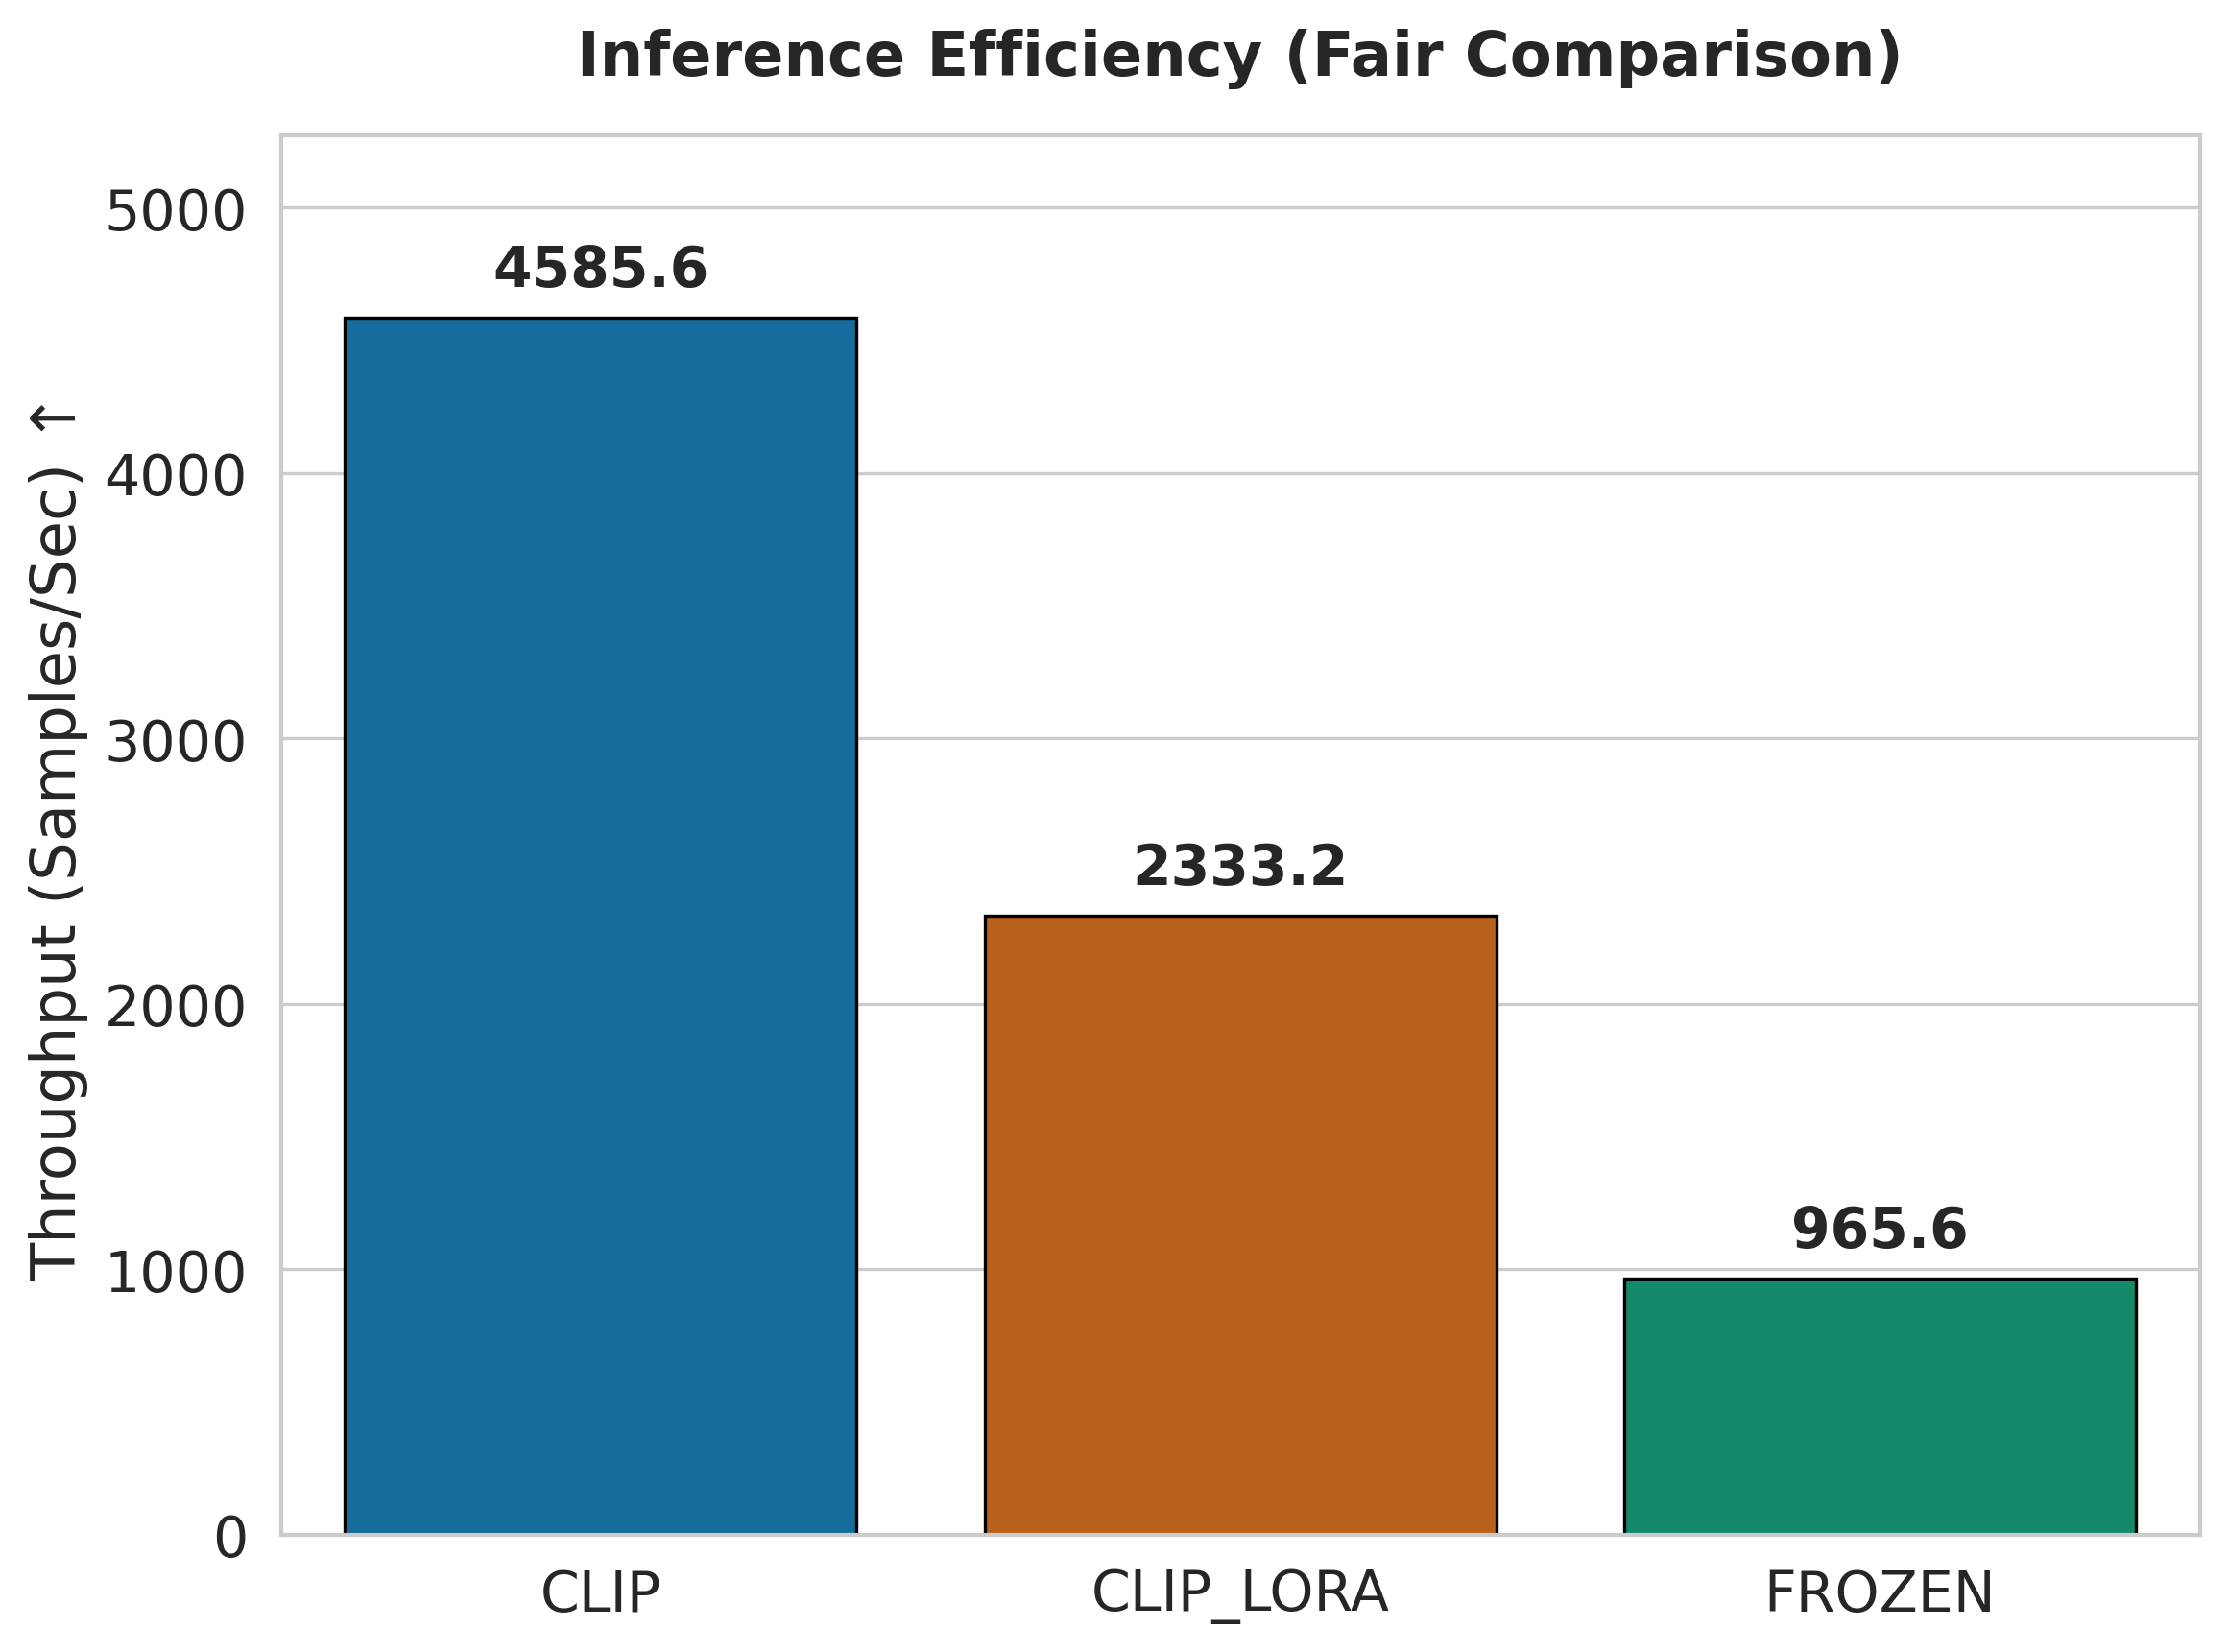

In [3]:
def plot_efficiency():
    # 1. Safety Check
    if not model_stats: 
        print("Warning: model_stats is empty. Skipping plot.")
        return

    # 2. Transform Dictionary to DataFrame
    # model_stats = {'CLIP': {'Throughput': 965...}, ...}
    # After .T (Transpose), rows are models, columns are metrics
    data = pd.DataFrame(model_stats).T.reset_index().rename(columns={"index": "Model"})
    
    plt.figure(figsize=(8, 6))
    
    # 3. Create Plot
    # Using 'hue' instead of 'palette' directly on x to avoid future Seaborn warnings
    ax = sns.barplot(
        data=data, 
        x="Model", 
        y="Throughput", 
        hue="Model", 
        palette=COLORS, 
        edgecolor="black",
        legend=False
    )
    
    # 4. Add Text Labels
    for p in ax.patches:
        height = p.get_height()
        # Only annotate if height is valid (avoids NaN issues)
        if height > 0:
            ax.annotate(f'{height:.1f}', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='bottom', fontsize=14, fontweight='bold', 
                        xytext=(0, 5), textcoords='offset points')

    plt.title("Inference Efficiency (Fair Comparison)", fontweight='bold', pad=15)
    plt.ylabel("Throughput (Samples/Sec) ↑")
    plt.xlabel("")
    
    # 5. Dynamic Y-Limit
    if not data["Throughput"].empty:
        plt.ylim(0, data["Throughput"].max() * 1.15) 
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "Fig1_Efficiency.png")
    plt.show()

plot_efficiency()

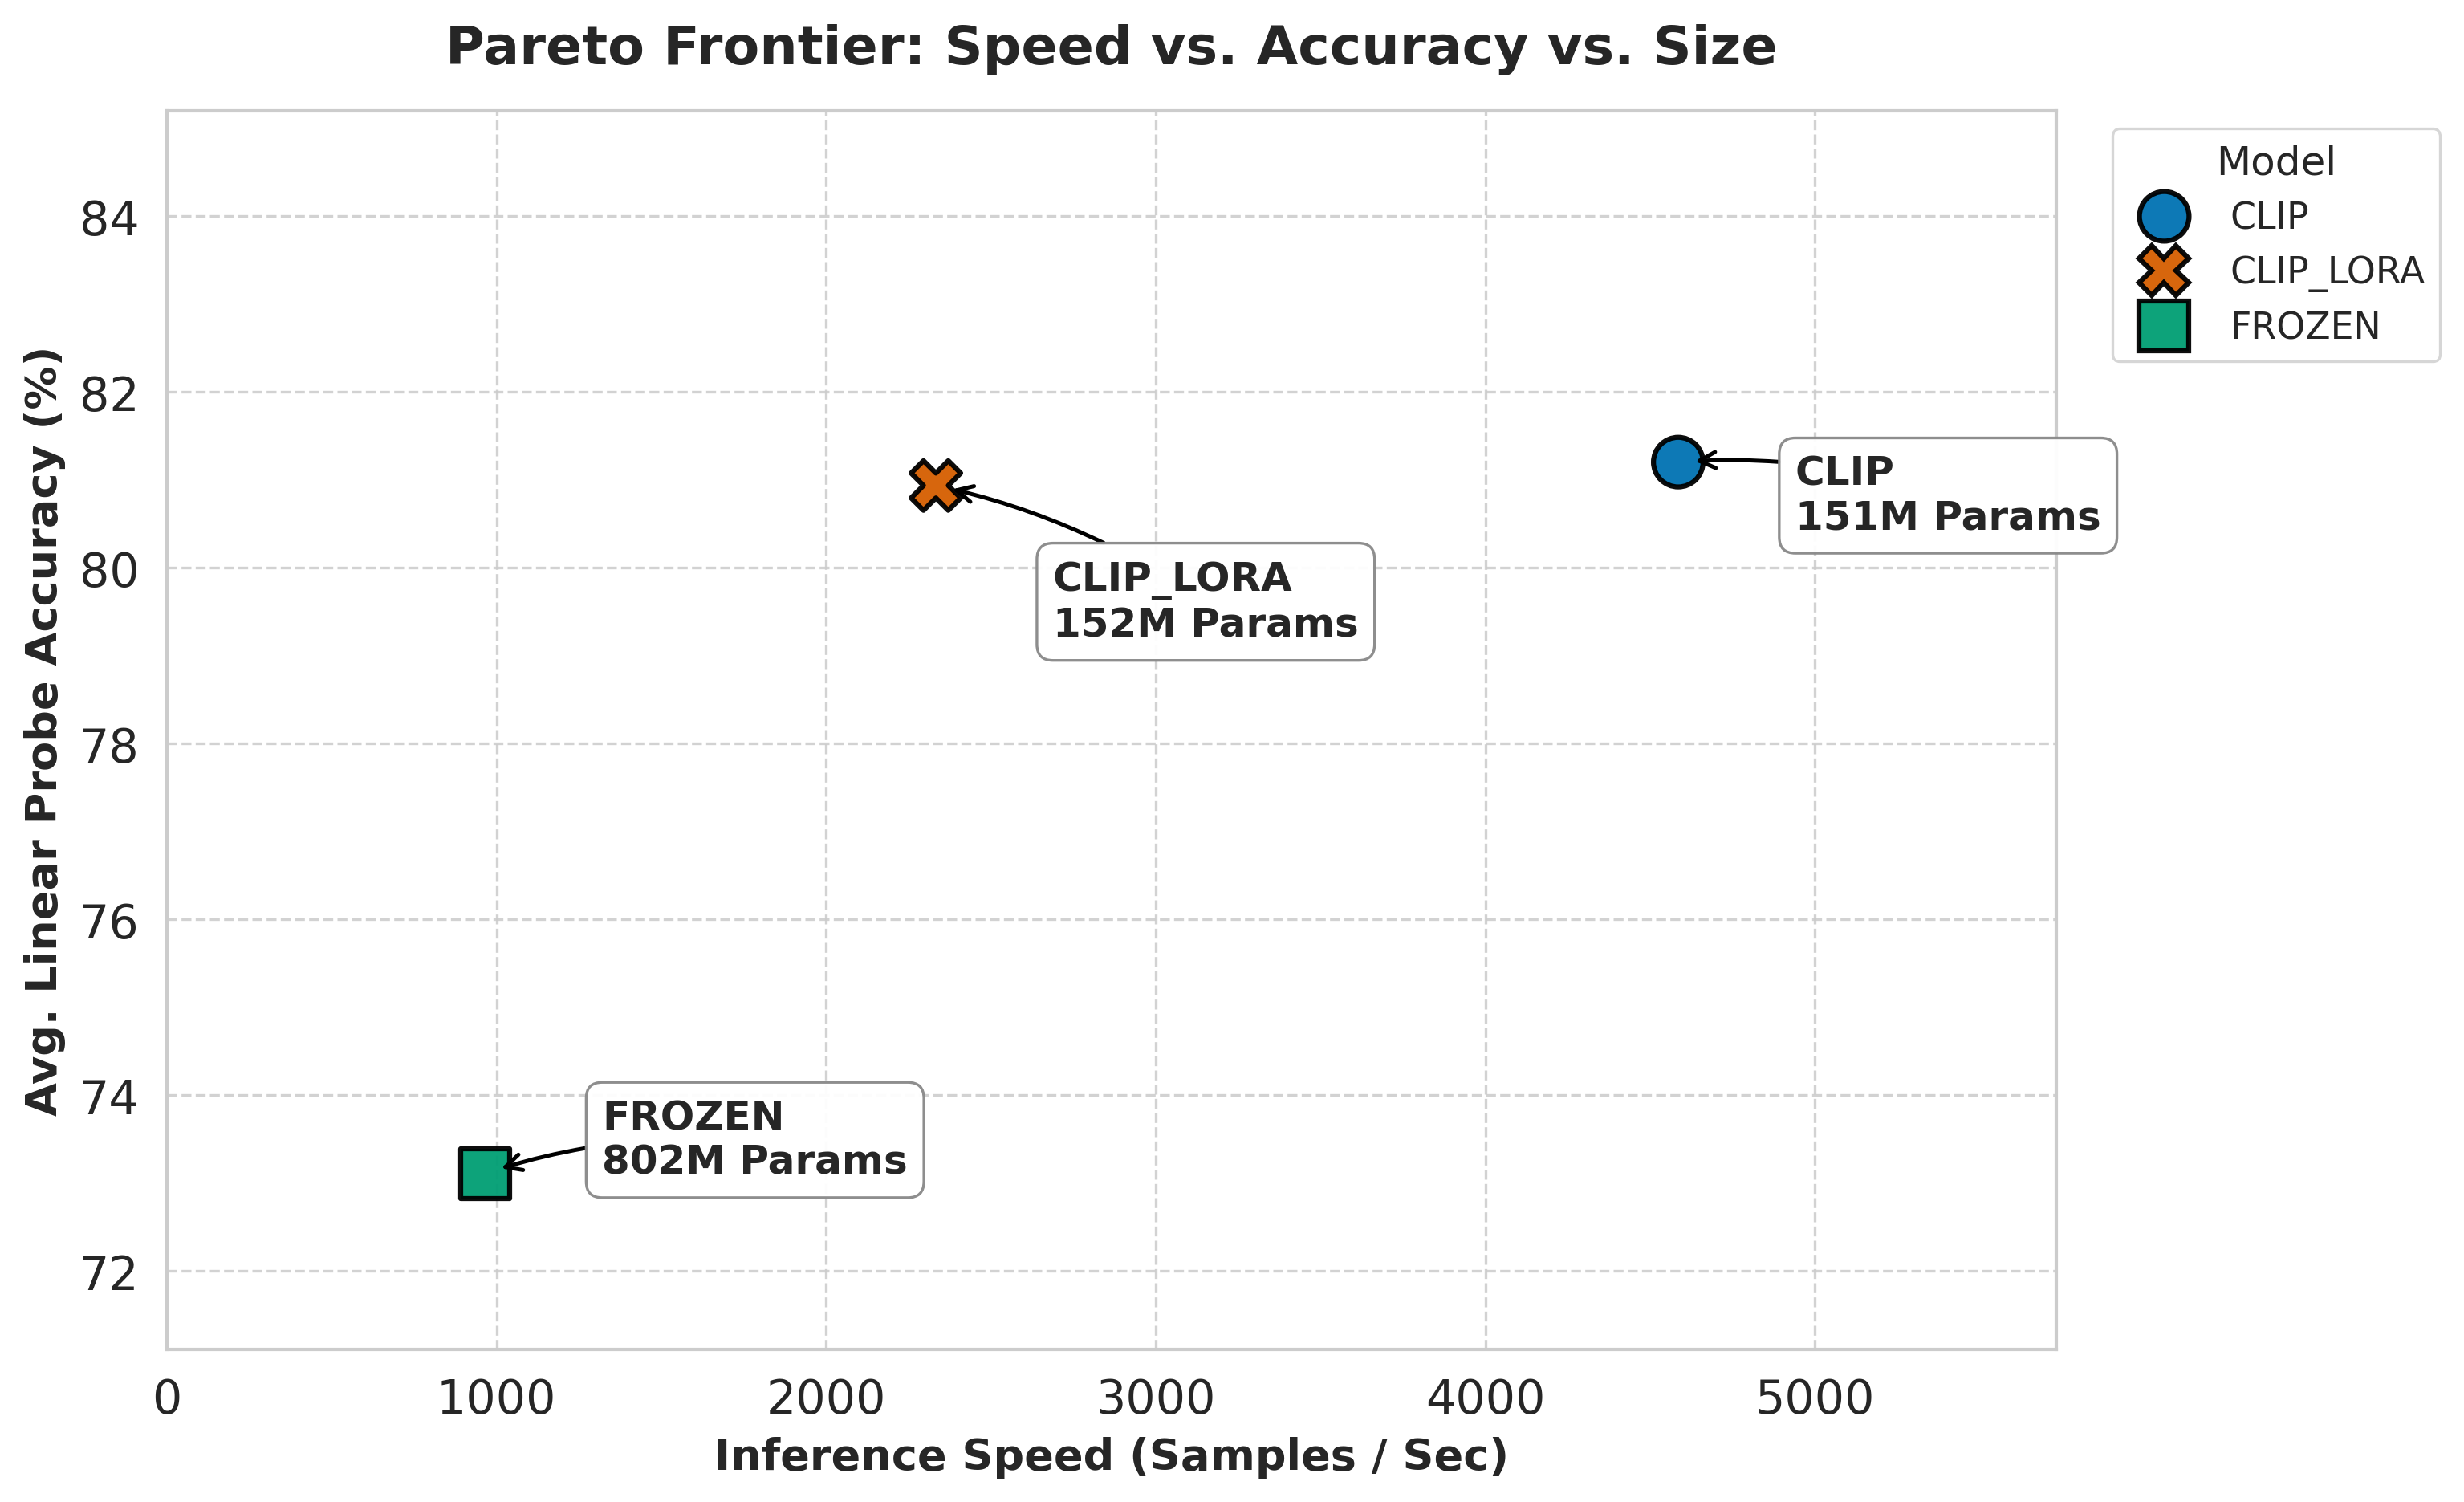

In [4]:
MARKERS = {"CLIP": "o", "CLIP_LORA": "X", "FROZEN": "s"} 

def plot_pareto_final():
    if not model_stats:
        print("Model stats are empty!")
        return

    # 1. PREPARE DATA & FIX COLUMN NAME
    # We rename 'Avg_LP_Acc' (from loader) to 'Avg_Acc' (for this plot)
    data = (
        pd.DataFrame(model_stats)
        .T.reset_index()
        .rename(columns={"index": "Model", "Avg_LP_Acc": "Avg_Acc"})
    )

    plt.figure(figsize=(10.5, 6.5))

    # 2. CLEAN SCATTER
    ax = sns.scatterplot(
        data=data,
        x="Throughput",
        y="Avg_Acc",
        hue="Model",
        style="Model",
        palette=COLORS,
        markers=MARKERS,    # Now defined above
        s=220,
        edgecolor="black",
        linewidth=1.5,
        alpha=0.95,
        legend=True
    )

    # 3. SMART, NON-OVERLAPPING LABELS
    offsets = {
        "CLIP": (35, -10),
        "CLIP_LORA": (35, -35),
        "FROZEN": (35, 10),
    }

    for _, row in data.iterrows():
        # Safety check: Default to (35, 0) if model not in offsets map
        dx, dy = offsets.get(row["Model"], (35, 0))

        ax.annotate(
            f"{row['Model']}\n{int(row['Params_M'])}M Params",
            xy=(row["Throughput"], row["Avg_Acc"]),
            xytext=(dx, dy),
            textcoords="offset points",
            ha="left",
            va="center",
            fontsize=12,
            fontweight="bold",
            bbox=dict(
                facecolor="white",
                edgecolor="#888",
                alpha=0.95,
                boxstyle="round,pad=0.4",
            ),
            arrowprops=dict(
                arrowstyle="->",
                lw=1.2,
                color="black",
                shrinkA=0,
                shrinkB=5,
                connectionstyle="arc3,rad=0.1",
            ),
        )

    # 4. LEGEND — MODEL ONLY
    ax.legend(
        title="Model",
        title_fontsize=12,
        fontsize=11,
        loc="upper left",
        bbox_to_anchor=(1.02, 1),
        frameon=True,
    )

    # 5. AXES, TITLE, GRID
    ax.set_title(
        "Pareto Frontier: Speed vs. Accuracy vs. Size",
        fontsize=16,
        fontweight="bold",
        pad=14,
    )
    ax.set_xlabel("Inference Speed (Samples / Sec)", fontsize=13, fontweight="bold")
    ax.set_ylabel("Avg. Linear Probe Accuracy (%)", fontsize=13, fontweight="bold")

    # Dynamic limits based on actual data
    if not data.empty:
        ax.set_xlim(0, data["Throughput"].max() * 1.25)
        ax.set_ylim(
            data["Avg_Acc"].min() - 2,
            data["Avg_Acc"].max() + 4,
        )

    ax.grid(True, linestyle="--", alpha=0.88)

    plt.tight_layout()
    plt.savefig(
        OUTPUT_DIR / "Fig2_Pareto_Frontier.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

plot_pareto_final()

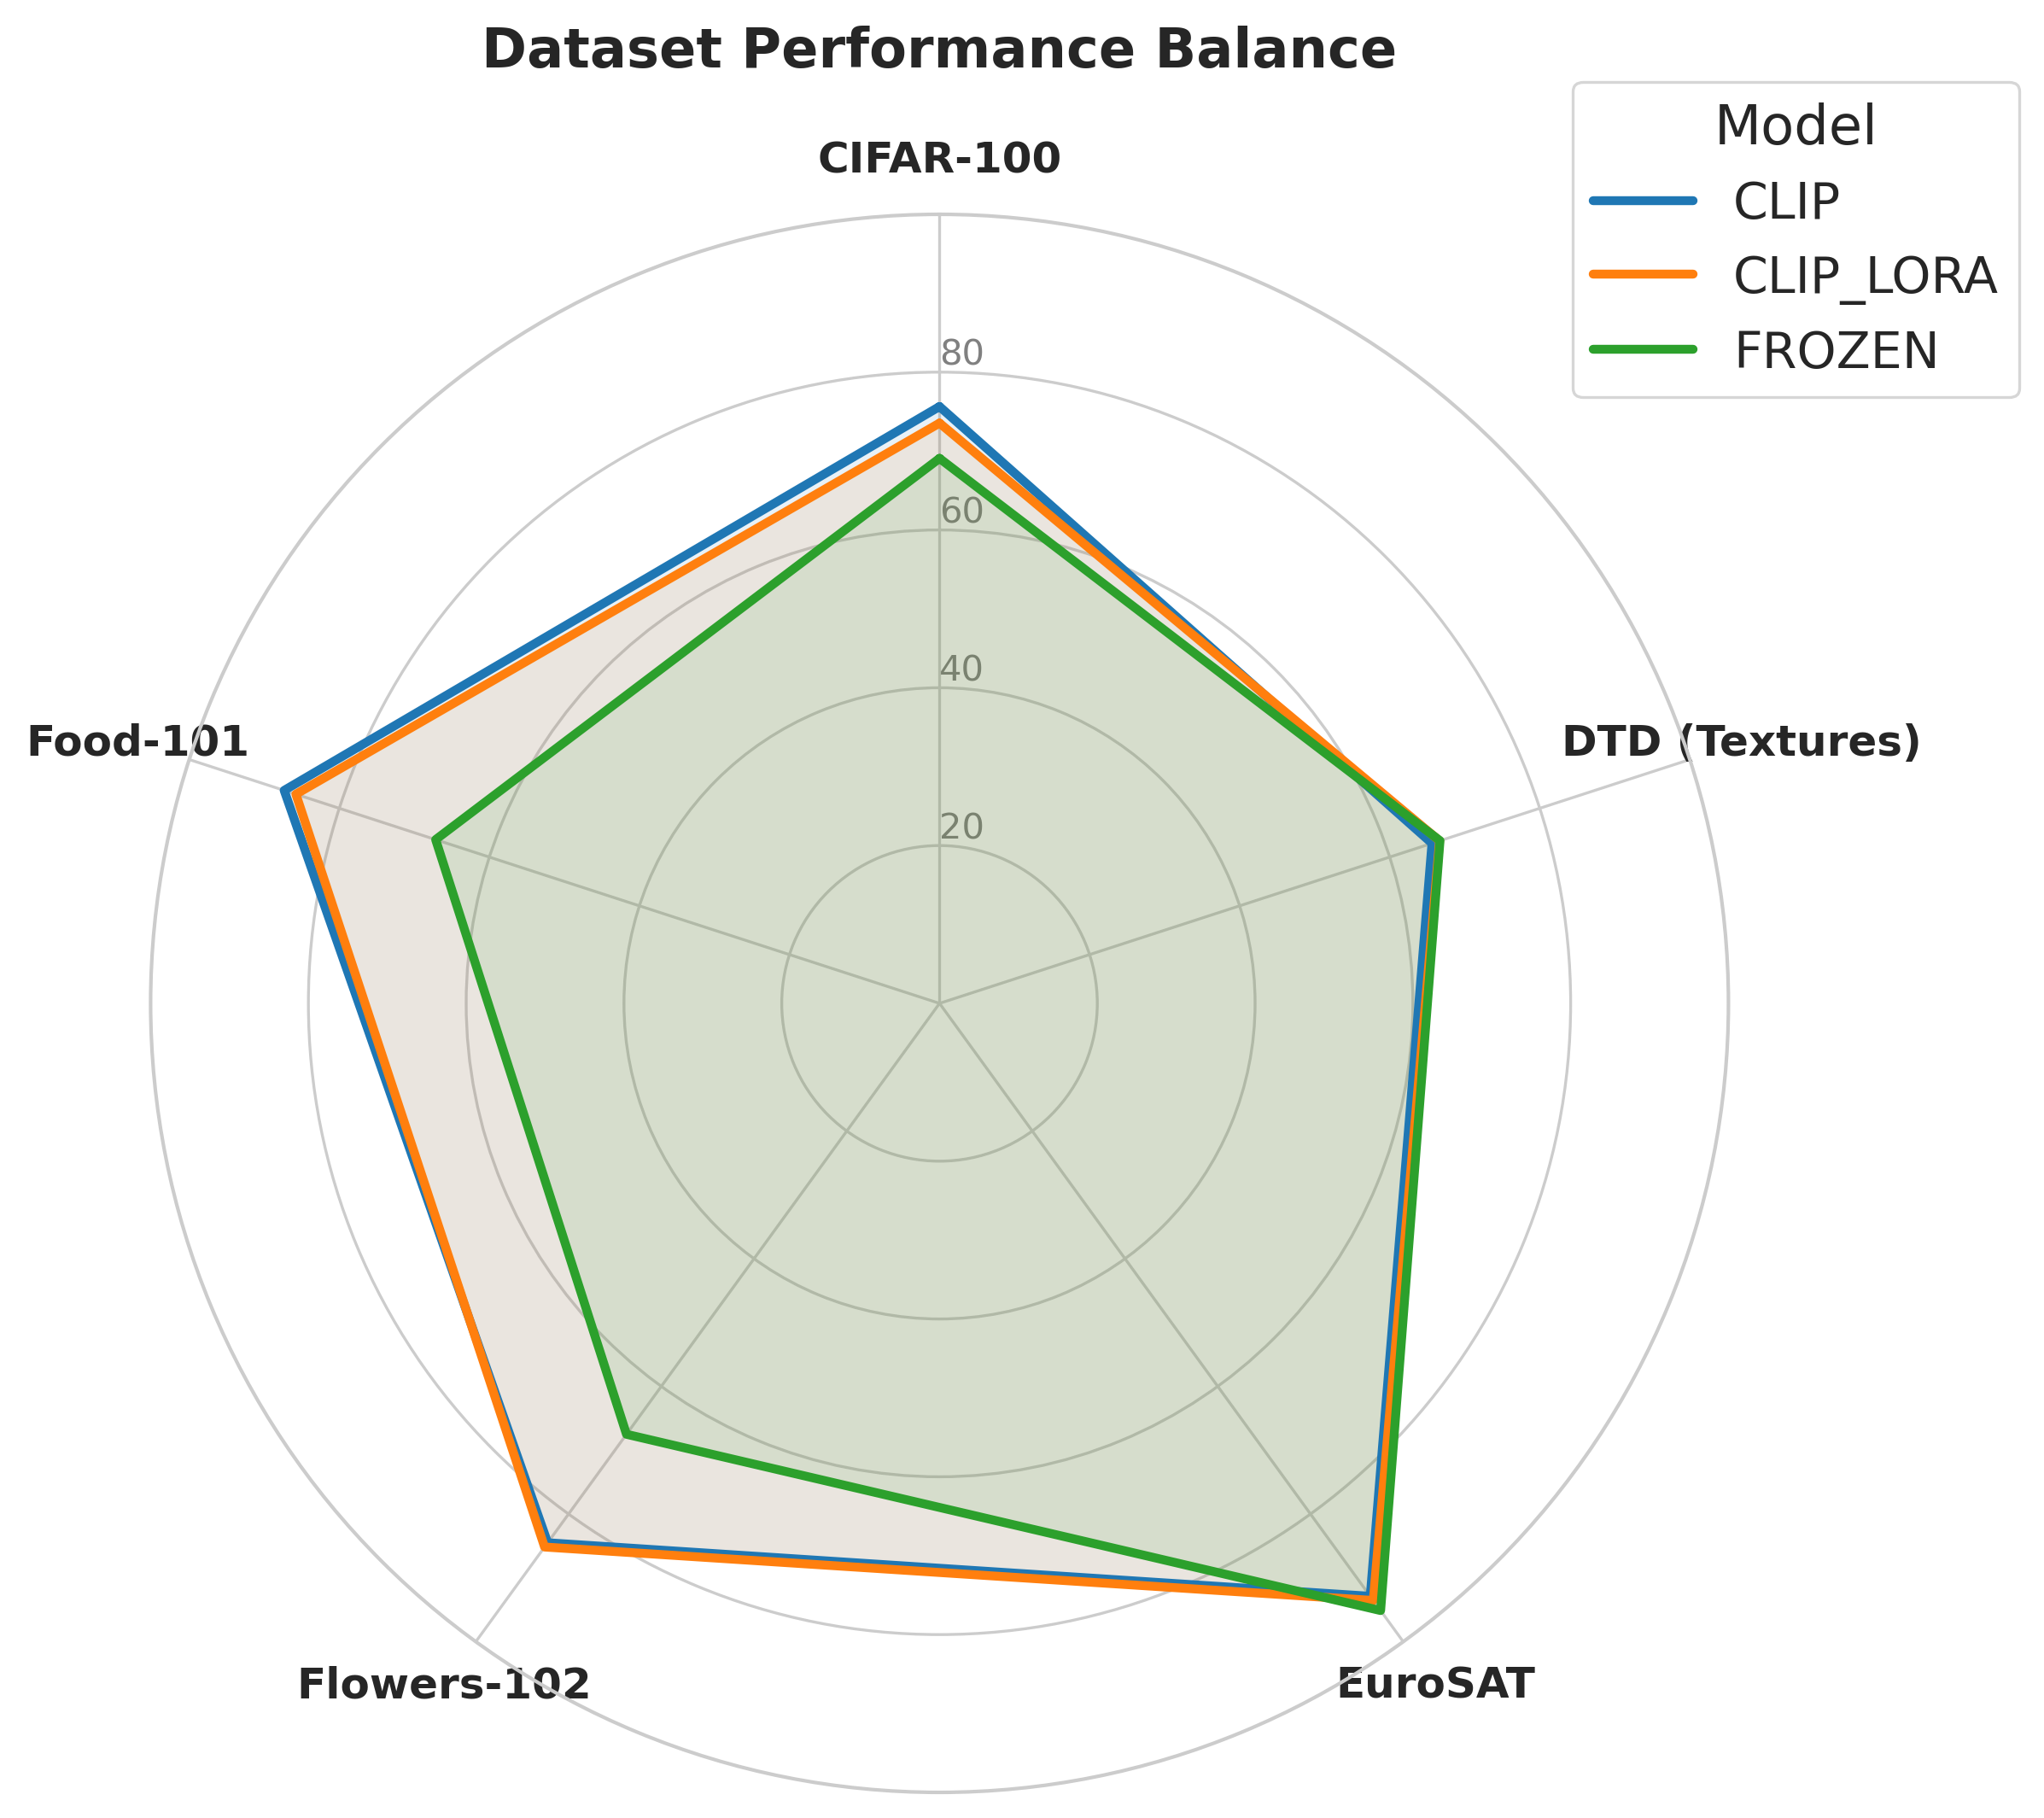

In [5]:
from math import pi
import matplotlib.pyplot as plt
import pandas as pd

def plot_radar():
    # 1. Safety Check
    lp_df = df[df["Task"] == "Linear Probe"].copy()
    if lp_df.empty: 
        print("No Linear Probe data found for radar chart.")
        return

    # 2. Fix Dataset Names (Official Capitalization) to match other plots
    name_map = {
        "CIFAR100": "CIFAR-100",
        "FOOD101": "Food-101",
        "FLOWERS102": "Flowers-102",
        "DTD": "DTD (Textures)",
        "EUROSAT": "EuroSAT"
    }
    lp_df["Dataset"] = lp_df["Dataset"].apply(lambda x: name_map.get(x, x))

    # 3. Pivot Data
    pivot = lp_df.pivot(index="Model", columns="Dataset", values="Value")
    labels = list(pivot.columns)
    num_vars = len(labels)
    
    # 4. Create Robust Color Mapping
    # We define valid HEX codes here to strictly prevent the "invalid color" error
    # Order: Blue (CLIP), Orange (CLIP_LORA), Green (FROZEN)
    safe_hex_colors = ["#1f77b4", "#ff7f0e", "#2ca02c"] 
    
    unique_models = pivot.index.tolist()
    
    # Map models to colors safely. 
    # If you have more models than 3, it cycles the colors.
    import itertools
    color_cycle = itertools.cycle(safe_hex_colors)
    model_colors = {model: next(color_cycle) for model in unique_models}

    # 5. Compute Angles
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1] # Close loop

    # 6. Initialize Plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # 7. Draw Lines
    for model in pivot.index:
        values = pivot.loc[model].tolist()
        values += values[:1] # Close loop
        
        c = model_colors[model] # This is guaranteed to be a hex code now
        
        ax.plot(angles, values, linewidth=2.5, linestyle='solid', label=model, color=c)
        ax.fill(angles, values, color=c, alpha=0.1)
    
    # 8. Style
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], labels, size=12, fontweight='bold')
    
    ax.set_rlabel_position(0)
    plt.yticks([20, 40, 60, 80], ["20", "40", "60", "80"], color="grey", size=10)
    plt.ylim(0, 100)
    
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), title="Model")
    plt.title("Dataset Performance Balance", fontweight='bold', y=1.08)
    
    plt.savefig(OUTPUT_DIR / "Fig3_Radar_Balance.png")
    plt.show()

plot_radar()

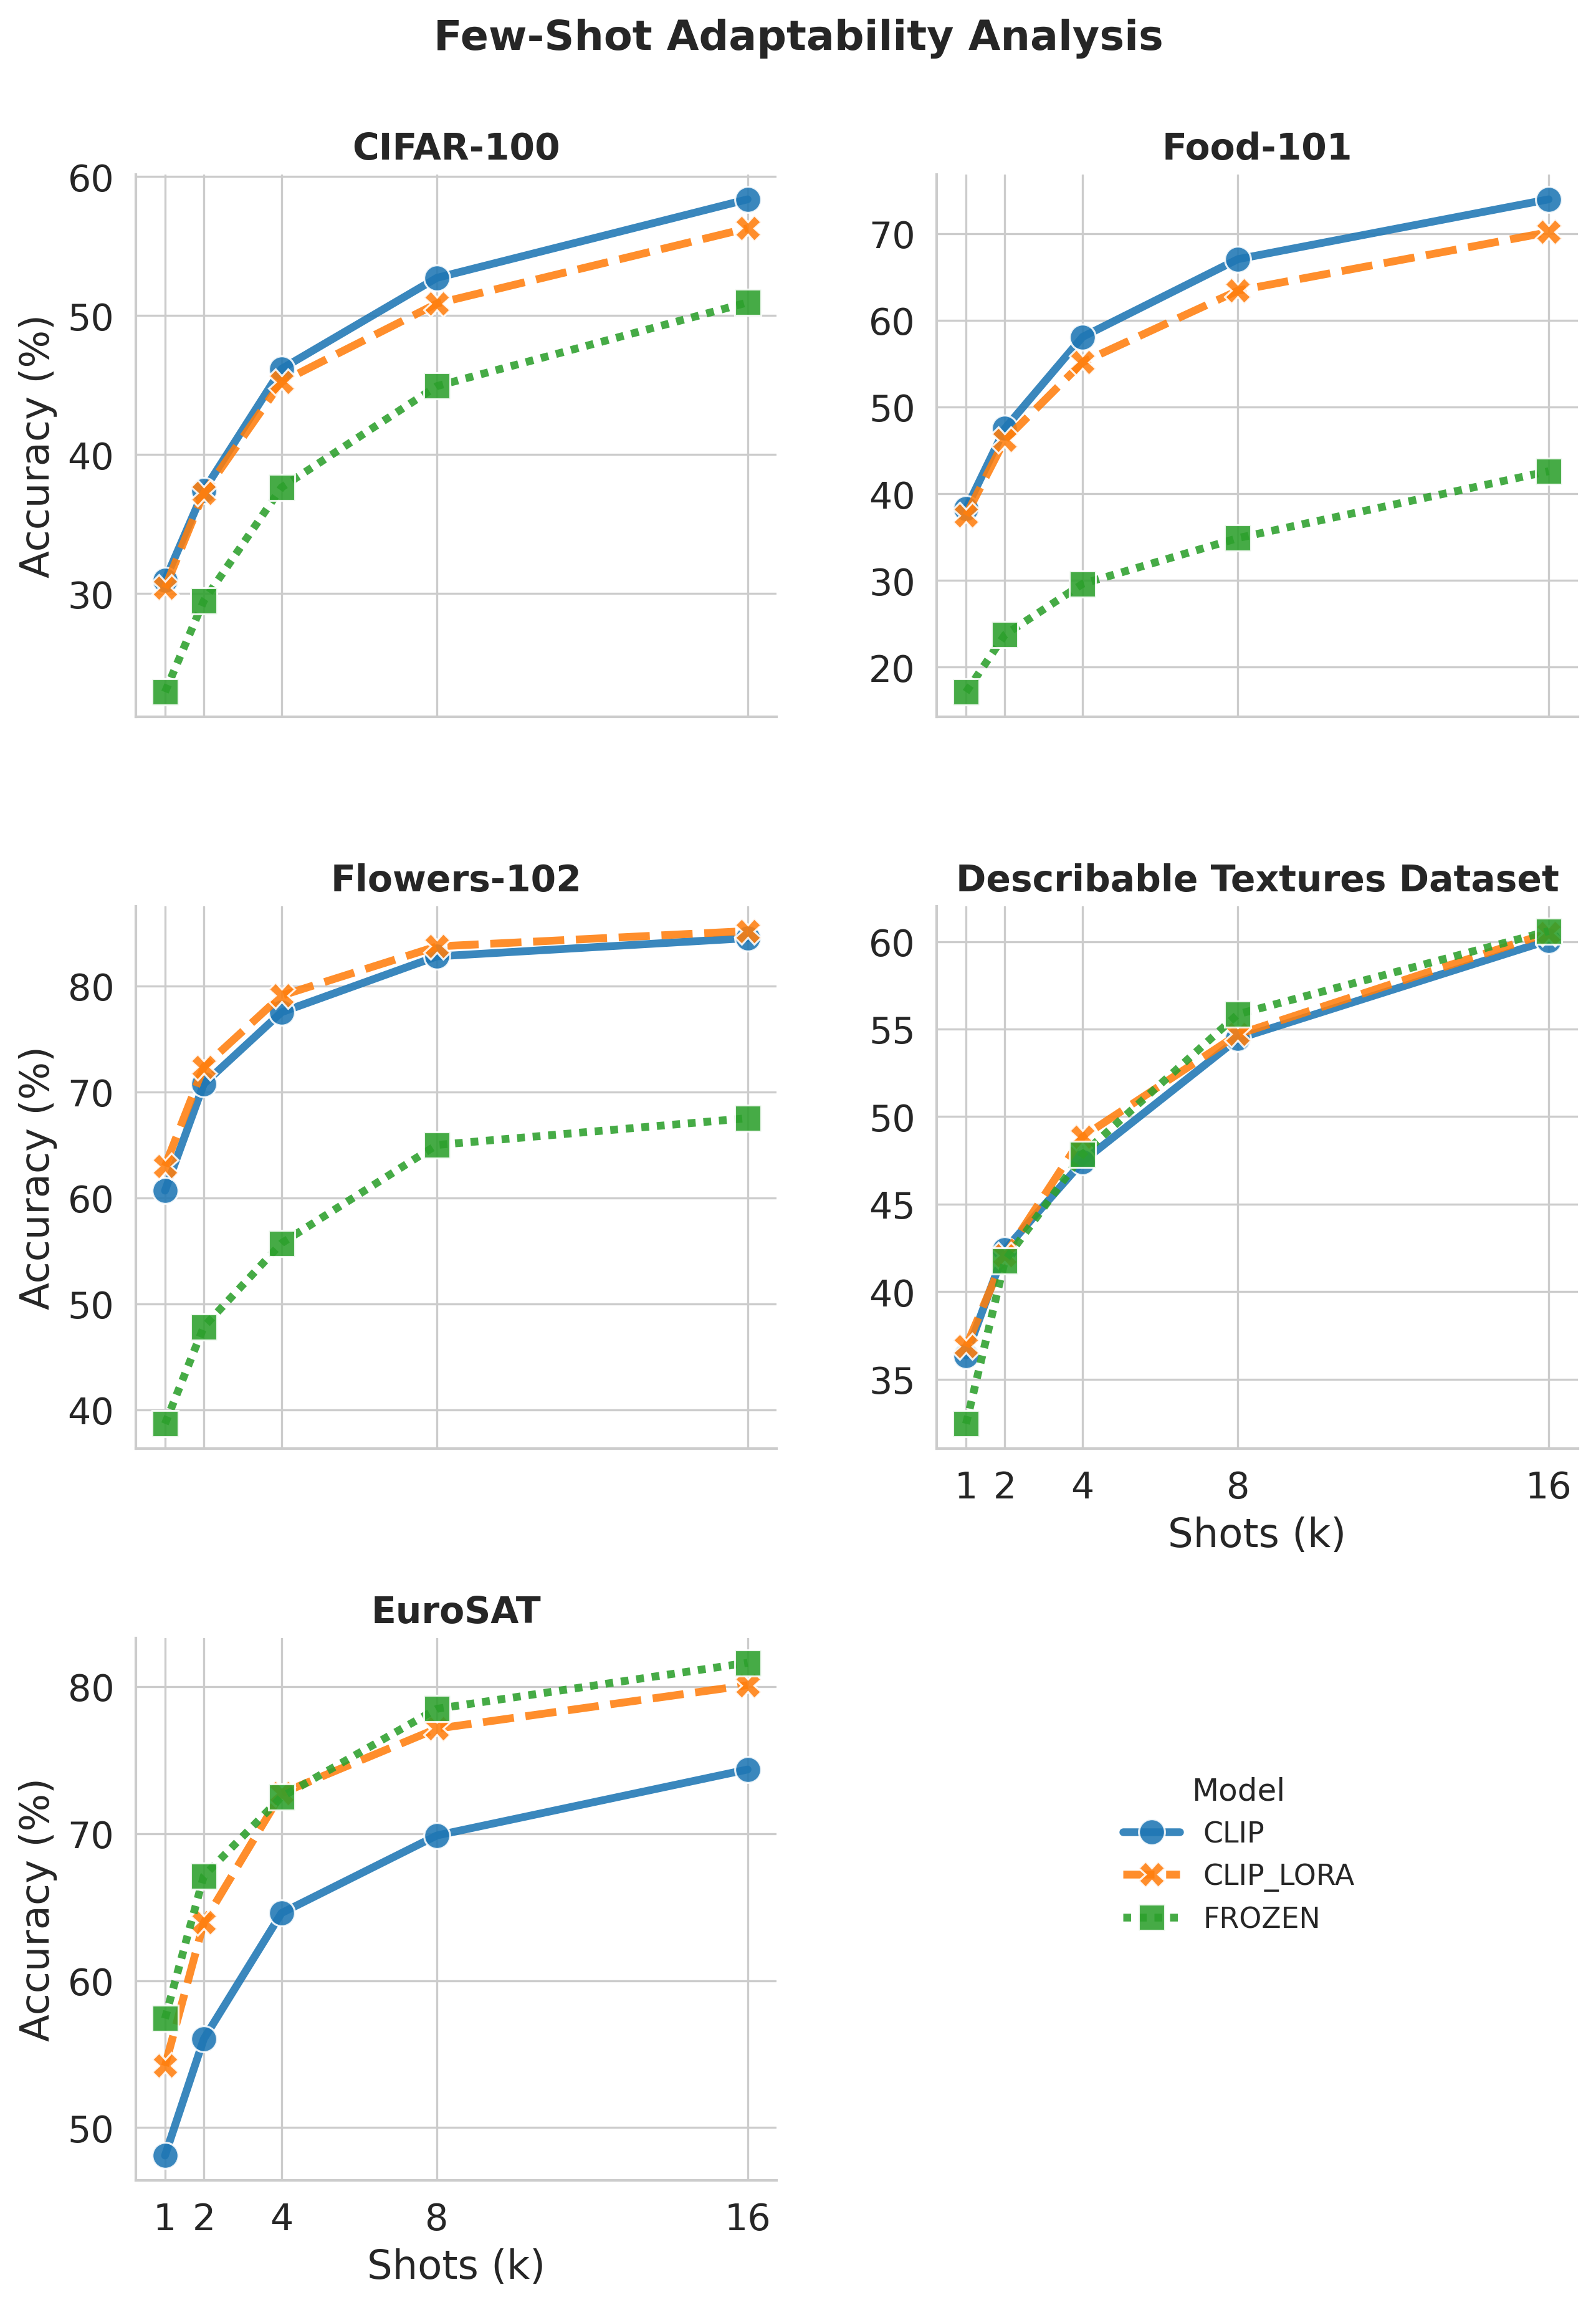

In [6]:
def plot_few_shot_curves():
    # 1. Safety Check
    data = df[df["Task"] == "Few-Shot"].copy() # Work on a copy to avoid warnings
    if data.empty:
        print("No Few-Shot data found.")
        return

    # 2. Fix Dataset Names (Official Capitalization)
    name_map = {
        "CIFAR100": "CIFAR-100",
        "FOOD101": "Food-101",
        "FLOWERS102": "Flowers-102",
        "DTD": "Describable Textures Dataset",
        "EUROSAT": "EuroSAT"
    }
    # Apply mapping (default to original if not found)
    data["Dataset"] = data["Dataset"].apply(lambda x: name_map.get(x, x))

    # 3. Style Definitions
    safe_markers = MARKERS if 'MARKERS' in globals() else {"CLIP": "o", "CLIP_LORA": "X", "FROZEN": "s"}
    
    if 'COLORS' in globals() and isinstance(COLORS, list):
        unique_models = sorted(data["Model"].unique())
        safe_palette = dict(zip(unique_models, COLORS))
    else:
        safe_palette = {"CLIP": "#1f77b4", "CLIP_LORA": "#ff7f0e", "FROZEN": "#2ca02c"}

    # 4. Create Grid
    g = sns.FacetGrid(
        data,
        col="Dataset",
        col_wrap=2,          # 2 columns means the 5th plot (EuroSAT) is on the bottom left
        height=4,
        aspect=1.1,
        sharey=False
    )

    # 5. Map Plots
    g.map_dataframe(
        sns.lineplot,
        x="Shots",
        y="Accuracy",
        hue="Model",
        style="Model",
        markers=safe_markers,
        palette=safe_palette,
        linewidth=3,
        markersize=10,
        alpha=0.88 
    )

    # 6. Formatting
    g.set_titles(col_template="{col_name}", fontweight="bold", size=14)
    g.set_axis_labels("Shots (k)", "Accuracy (%)")
    g.set(xticks=[1, 2, 4, 8, 16])

    # 7. Move Legend to Empty Space (Right of EuroSAT)
    # The EuroSAT plot is the last active axis (index 4). 
    # We anchor the legend to the RIGHT of this axis.
    last_ax = g.axes[-1] 
    
    # Get handles/labels from the last axis to build the legend
    handles, labels = last_ax.get_legend_handles_labels()
    
    last_ax.legend(
        handles=handles, 
        labels=labels,
        title="Model",
        title_fontsize=12,
        fontsize=11,
        # (1.2, 0.5) places it to the right of the subplot
        bbox_to_anchor=(1.5, 0.6), 
        loc='center left',
        frameon=False
    )

    g.fig.subplots_adjust(wspace=0.25, hspace=0.35)

    plt.suptitle(
        "Few-Shot Adaptability Analysis",
        y=1.03,
        fontweight="bold",
        size=16
    )

    plt.savefig(
        OUTPUT_DIR / "Fig4_FewShot_Curves.png",
        bbox_inches="tight",
        dpi=300
    )
    plt.show()

plot_few_shot_curves()